<div class="frontmatter text-center">
<h1>Geospatial Data Science</h1>
<h2>Lecture 2: Geospatial Data in Python</h2>
<h3>IT University of Copenhagen, Spring 2024</h3>
<h3>Instructor: Michael Szell</h3>
</div>

This notebook was adapted from:
* A course on Geographic Data Science: https://darribas.org/gds_course/content/bC/lab_C.html
* Automating GIS-Processes: https://autogis-site.readthedocs.io/en/latest/notebooks/L2/02-projections.html

# PART 1: GEOPANDAS & VECTOR DATA

### Imports

In [1]:
import geopandas as gpd # for geospatial data handling
import pandas as pd
import osmnx # for handling data from OpenStreetMap (osm) with the help of networkX (nx)
import contextily as cx # for plotting
import matplotlib.pyplot as plt # for plotting
from pyproj import CRS # for more advanced CRS modifications and transformations

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


In this lecture, we will learn how to **load, manipulate** and **visualize** spatial data with a focus on *vector* data. 

In some senses, spatial data are usually included simply as "one more column" in a table. However, *spatial is special* sometimes and there are few aspects in which geographic data differ from standard numerical tables. Dealing with spatial data in Python largely resembles dealing with non-spatial data.

## Introduction to GeoPandas

GeoPandas - the spatial extension of pandas - is one of the core libraries for doing geospatial analysis in Python.

There are various different GIS data formats available such as [GPKG](https://en.wikipedia.org/wiki/GeoPackage), [GeoJSON](https://en.wikipedia.org/wiki/GeoJSON), [KML](https://en.wikipedia.org/wiki/Keyhole_Markup_Language), and [Shapefile](https://en.wikipedia.org/wiki/Shapefile). [Geopandas](https://geopandas.org/en/stable/docs/user_guide/io.html) is capable of reading data from all of these formats (plus many more) and combines the capabilities of the data analysis library [pandas](https://pandas.pydata.org/pandas-docs/stable/) with other packages like [shapely](https://shapely.readthedocs.io/en/stable/manual.html) and [fiona](https://fiona.readthedocs.io/en/latest/manual.html) for managing spatial data. 

The main data structures in geopandas are `GeoSeries` and `GeoDataFrame` which extend the capabilities of `Series` and `DataFrames` from pandas. This means that we can use all our pandas skills also when working with geopandas - with some added spatial functionalities 🌐

The main difference between geodataframes and pandas dataframes is that a [geodataframe](https://geopandas.org/en/stable/docs/user_guide/data_structures.html#geodataframe) should contain one column for **geometries**. By default, the name of this column is `'geometry'`. The geometry column is a [geoseries](https://geopandas.org/en/stable/docs/user_guide/data_structures.html#geoseries) which contains the geometries (points, lines, polygons, multipolygons etc.) as shapely objects. More info here: https://geopandas.org/en/stable/getting_started/introduction.html

<img src="files/dataframe.svg">

## Datasets

To learn these concepts, we will be playing with three main datasets: Cities, streets, and bars in Spain. These datasets can be loaded dynamically from the web, or from your computer.

Regardless of file format, we use the `gpd.read_file()` method. To save files, use `gpd.save_file()`.

### Cities

We will use an open dataset that contains the boundaries of Spanish cities as *polygons*. We can read it into an object named `cities` by:

In [2]:
cities = gpd.read_file("https://ndownloader.figshare.com/files/20232174")

The code cell above requires internet connectivity. If you are not online you can read the data from your computer with the following line of code: 

In [ ]:
cities = gpd.read_file("files/cities.gpkg")

We can check that this actually produced a GeoDataFrame....

In [3]:
type(cities)

geopandas.geodataframe.GeoDataFrame

...and get a sample of the data like this:

In [4]:
cities.sample(5)

,city_id,n_buildings,geometry
361,ci403,7813,"POLYGON ((434672.232 4504263.979, 434916.736 4..."
578,ci654,3727,"POLYGON ((446053.946 4614783.909, 446079.798 4..."
318,ci351,3614,"POLYGON ((43042.169 4682707.967, 43007.218 468..."
277,ci304,3258,"POLYGON ((733998.062 4404048.778, 734283.126 4..."
342,ci380,3265,"POLYGON ((884153.939 4579796.894, 884150.988 4..."


Now `cities` is a `GeoDataFrame`. Very similar to a traditional, non-spatial `DataFrame`, but with an additional column called `geometry`. You should recognize the geometry data from last week's introduction to Shapely!


In [5]:
cities.geometry.head()

0    POLYGON ((385390.071 4202949.446, 384488.697 4...
1    POLYGON ((214893.033 4579137.558, 215258.185 4...
2    POLYGON ((690674.281 4182188.538, 691047.526 4...
3    POLYGON ((513378.282 4072327.639, 513408.853 4...
4    POLYGON ((206989.081 4129478.031, 207275.702 4...
Name: geometry, dtype: geometry

### Streets

In addition to polygons, we will play with a line layer. For that, we are going to use a subset of street network from the Spanish city of Madrid. 

This dataset is from of a project called "Las calles de las mujeres", a community-driven initiative exploring the extent to which streets are named after women. 

Check out more about the project, including an interactive map at: [https://geochicasosm.github.io/lascallesdelasmujeres/](https://geochicasosm.github.io/lascallesdelasmujeres/)

The data is available on the following web address:

In [6]:
url = (
    "https://github.com/geochicasosm/lascallesdelasmujeres"
    "/raw/master/data/madrid/final_tile.geojson"
)

And you can read it into an object called `streets` with:

In [7]:
streets = gpd.read_file(url)

The code cell above also requires internet connectivity. If you are not online, you can read the data with the following line of code: 

In [8]:
streets = gpd.read_file("files/streets.geojson")

In [9]:
streets.head(3)

,name,id,wikipedia_link,gender,scale,category,typeofroad,geometry
0,Plaza Virgen de la Capilla,123483746,,Female,,-,-,"POLYGON ((-3.71472 40.48250, -3.71460 40.48229..."
1,Plaza Nuestra Señora del Prado,123483930,,Female,,-,-,"POLYGON ((-3.71404 40.48271, -3.71392 40.48249..."
2,Avenida del Cardenal Herrera Oria,4272448,,Male,,None,None,"LINESTRING (-3.71421 40.48307, -3.71407 40.483..."


To explore what type of geometries our geodataframe contains - maybe there's more than one? - we use `geom_type`:

In [10]:
streets.geom_type.unique()

array(['Polygon', 'LineString'], dtype=object)

For this tutorial, we however only want the streets with a Linestring-geometry:

In [11]:
streets = streets.loc[streets.geom_type=='LineString']
streets.geom_type.unique()

array(['LineString'], dtype=object)

### Bars

The final dataset we will rely on is a set of points demarcating the location of bars in Madrid. To obtain it, we will use `osmnx`, a Python library that allows us to query [OpenStreetMap](https://www.openstreetmap.org) (you will learn much more about this later!). Note that we use the method `pois_from_place`, which queries for points of interest (POIs, or `pois`) in a particular place (Madrid in this case). In addition, we can specify a set of tags to delimit the query. We use this to ask _only_ for amenities of the type "bar":

In [12]:
pois = osmnx.geometries_from_place(
    "Madrid, Spain", tags={"amenity": "bar"}
)

/opt/conda/lib/python3.9/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


You do not need to know at this point what happens behind the scenes when we run `geometries_from_place` but, if you are curious, we are making a query to [OpenStreetMap](https://www.openstreetmap.org) (almost as if you typed "bars in Madrid, Spain" within Google Maps) and getting the response as a table of data, instead of as a website with an interactive map. Pretty cool, huh?

#### Non-spatial file formats
In all of the above, the data sets were already spatial data formats with defined geometries. It is however also possible to convert a csv with for example x,y-coordinates to a GeoDataFrame, with only a bit more code:

In [13]:
df = pd.read_csv('files/pois_xy.csv')

gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.x, df.y) # columns with x and y coordinates in dataframe
)

---

## Inspecting spatial data

The most direct way to get from a file to a quick visualization of the data is by loading it as a `GeoDataFrame` and calling the `plot` command.

It is always a good idea to start with plotting your data to get an overview - so make use of spatial data's natural visual component!

In two lines of code, we will obtain a graphical representation of the spatial data contained in a file. Let us start by plotting single layers in a crude but quick form, and we will build style and sophistication into our plots later on.

### Polygons

The most simple way is simply to call `geodataframe.plot()`:

/opt/conda/lib/python3.9/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/opt/conda/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


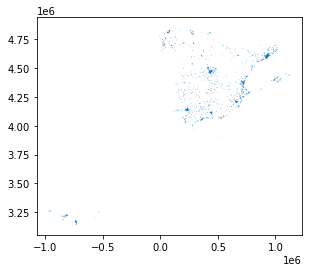

In [14]:
cities.plot();

This might not be the most aesthetically pleasant visual representation of cities, but it is hard to argue it is not quick to produce. We will work on styling and customizing spatial plots later on.

For a quick, interactive map, use the build-in method `explore()`:

In [15]:
cities.explore()

This produced an interactive folium map, with a background map, zoom, and data values shown on hover! (We will learn how to build and customize our own interactive maps later).
For large data sets, this method can be slow.

**Tip**: if you call a single row of the `geometry` column, it'll return a small plot with the shape:

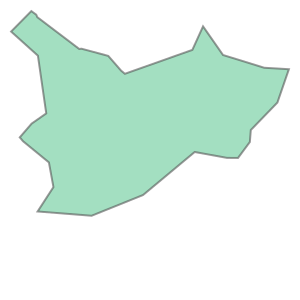

In [19]:
cities.loc[0, 'geometry']

### Lines

Similarly to the polygon case, if we pick the `"geometry"` column of a table with lines, a single row will display the geometry as well:

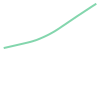

In [20]:
streets.loc[2, 'geometry']

A quick plot is similarly generated by:

/opt/conda/lib/python3.9/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/opt/conda/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


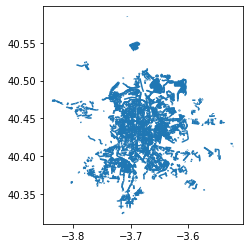

In [21]:
streets.plot();

Again, this is not the prettiest way to display the streets maybe, and you might want to change a few parameters such as colors, etc. All of this is possible, as we will see below, but this gives us a quick idea of what lines look like.

### Points

Points take a similar approach for quick plotting:

/opt/conda/lib/python3.9/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/opt/conda/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/opt/conda/lib/python3.9/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/opt/conda/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


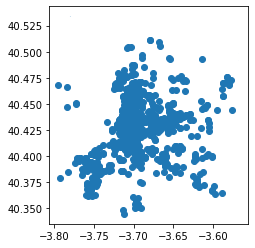

In [22]:
pois.plot();

## Manipulating spatial data with GeoPandas

Once we have an understanding of how to explore our spatial data, let us see some of the methods GeoPandas has for working with spatial data. Essentially, the key is to realize that a `GeoDataFrame` (gdf) contains most of its spatial information in a single column named `geometry`, but the rest of it looks and behaves exactly like a non-spatial `DataFrame` (in fact, it is).

GeoDataFrames come with a whole range of traditional GIS operations built-in. Here we will run through a small subset of them that contains some of the most commonly used ones.

### Area calculation

One of the spatial aspects we often need from polygons is their area. "How big is it?" is a question that always haunts us when we think of countries, regions, or cities. To obtain area measurements, first make sure your `GeoDataFrame` is in a *projected* CRS. GeoPandas will issue a warning if you try to do distance or area computations in a geographic CRS.

In [23]:
city_areas = cities.area
city_areas.head()

0    8.449666e+06
1    9.121270e+06
2    1.322653e+07
3    6.808121e+07
4    1.072284e+07
dtype: float64

This indicates that the area of the first city in our table takes up 8,450,000 squared metres. Notice that GeoPandas automatically know to use the `geometry`column for the area calculation.

If we wanted to convert into squared kilometres, we can divide by 1,000,000:

In [25]:
areas_in_sqkm = city_areas / 1000000
areas_in_sqkm.head()

0     8.449666
1     9.121270
2    13.226528
3    68.081212
4    10.722843
dtype: float64

### Length

An equally common question about lines is their *length*. This computation is straightforward in Python, again provided that our data are projected.
Let's first try a simple length calculation:

In [26]:
streets.length.head(5)

/tmp/ipykernel_193/2662585423.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  streets.length.head(5)


2    0.004375
3    0.001594
4    0.001151
5    0.000087
6    0.001099
dtype: float64

As you can see, all the streets look very short (??) and GeoPandas is complaining. That is because the streets are in a *geographic* CRS, which means that the street lengths are measured in degrees!
To fix this, we can change the geometries to a projected CRS (`to_crs`) and calculate the length at the same time:

In [27]:
street_length = streets.to_crs(epsg=25830).length
street_length.head()

2    396.494357
3    152.442895
4    101.392357
5      8.820575
6    119.172430
dtype: float64

Since the CRS we use (`EPSG:25830`) is expressed in metres, we can tell the first street segment is about 370m.

### Centroid calculation

Sometimes it is useful to summarize a polygon into a single point and, for that, a good candidate is its centroid (almost like a spatial analogue of the average). The following command will return a `GeoSeries` (a single column with spatial data) with the centroids of a polygon `GeoDataFrame`:

In [30]:
cents = cities.centroid
cents.head()

0    POINT (386147.759 4204605.994)
1    POINT (216296.159 4579397.331)
2    POINT (688901.588 4180201.774)
3    POINT (518262.028 4069898.674)
4    POINT (206940.936 4127361.966)
dtype: geometry

Note how `cents` is not an entire table but a single column, or a `GeoSeries` object. This means you can plot it directly, just like a table:

/opt/conda/lib/python3.9/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/opt/conda/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


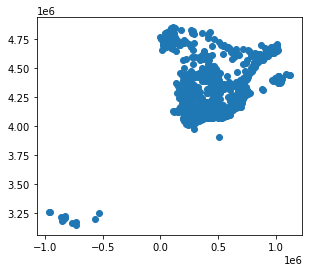

In [29]:
cents.plot();

### Point in polygon (PiP)

Knowing whether a point is inside a polygon is conceptually a straightforward exercise but computationally a tricky task to perform. The way to perform this operation in `GeoPandas` is through the `contains` method, available for each polygon object.

The `contains()`method is only one in a family of spatial topology operations, such as `intersects`, `touces`, `within`, etc.

In [31]:
poly = cities.loc[12, "geometry"] # select one city
pt1 = cents[0] # centroid of a city
pt2 = cents[12] # centroid of another city

And we can perform the checks as follows:

In [32]:
poly.contains(pt1)

False

In [33]:
poly.contains(pt2)

True

Performing point-in-polygon in this way is instructive and useful for pedagogical reasons, but for cases with many points and polygons, it is not particularly efficient. In these situations, it is much more advisable to perform them as a **[spatial join](https://geopandas.org/en/stable/docs/user_guide/mergingdata.html#spatial-joins)**.

Similarly, the Geopandas method `overlay()` is an efficient way of performing spatial **[set-based operations](https://geopandas.org/en/stable/docs/user_guide/set_operations.html)**  (*intersection, unions, difference*, etc.)

### Buffers

Buffers are one of the classical geospatial operations in which an area is drawn around a particular geometry, based on a chosen radius. These are very useful, for instance, in combination with point-in-polygon operations to calculate accessibility, catchment areas, etc.

For this example, we will use the bars table, but will **reproject** it to the same CRS as `cities`, so it is expressed in metres:

In [34]:
pois_projected = pois.to_crs(cities.crs) #more on CRS below!

To create a buffer using `GeoPandas`, simply call the `buffer` method, passing in the radius. For example, to draw a 500m. buffer around every bar in Madrid:

In [35]:
buf = pois_projected.buffer(500)
buf.head()

element_type  osmid    
node          26808561     POLYGON ((440085.400 4475245.186, 440082.992 4...
              43274445     POLYGON ((441199.443 4482099.370, 441197.035 4...
              47216276     POLYGON ((440012.154 4473848.877, 440009.747 4...
              167301896    POLYGON ((441631.862 4473439.094, 441629.454 4...
              167301964    POLYGON ((441283.067 4473680.493, 441280.659 4...
dtype: geometry

Notice how the geometries are now polygons!

Plotting it is equally straighforward:

/opt/conda/lib/python3.9/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/opt/conda/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/opt/conda/lib/python3.9/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/opt/conda/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/opt/conda/lib/python3.9/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are depreca

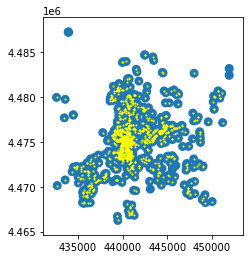

In [38]:
f, ax = plt.subplots(1)
# Plot buffer
buf.plot(ax=ax, linewidth=0)
# Plot named places on top for reference
# [NOTE how we modify the dot size (`markersize`) and the color (`color`)]
pois_projected.plot(ax=ax, markersize=1, color='yellow');

## Styling plots

It is possible to tweak several aspects of a plot to customize if to particular needs. In this section, we will explore some of the basic elements that will allow us to obtain more compelling maps. In this tutorial we use matplotlib because GeoPandas comes with build in methods for matplotlib plotting - but we will later encounter other methods for plotting spatial data in Python.

### Changing transparency

The intensity of color of a polygon can be easily changed through the `alpha` attribute in plot. This is specified as a value betwee zero and one, where the former is entirely transparent while the latter is the fully opaque (maximum intensity):

/opt/conda/lib/python3.9/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/opt/conda/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/opt/conda/lib/python3.9/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/opt/conda/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


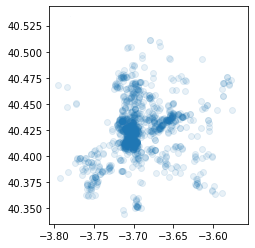

In [39]:
pois.plot(alpha=0.1);

### Removing axes

Although in some cases, the axes - which shows the location of the data in the CRS used - can be useful to obtain context, maps often look and feel better without them. Removing the axes involves wrapping the plot into a figure, which takes a few more lines of aparently useless code but that, in time, it will allow you to tweak the map further and to create much more flexible designs:

/opt/conda/lib/python3.9/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/opt/conda/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


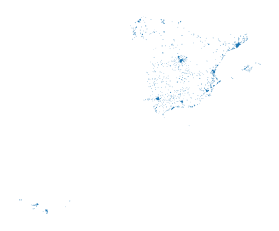

In [40]:
# Setup figure and axis
f, ax = plt.subplots(1)
# Plot layer of polygons on the axis
cities.plot(ax=ax)
# Remove axis frames
ax.set_axis_off()
# Display
plt.show() # Not always necessary - but can be with more advanced tinkering with the plotting settings

Let us stop for a second a study each of the previous lines:

1. We have first created a figure named `f` with one axis named `ax` by using the command `plt.subplots` (part of the library `matplotlib`, which we have imported at the top of the notebook). Note how the method is returning two elements and we can assign each of them to objects with different name (`f` and `ax`) by simply listing them at the front of the line, separated by commas.
2. Second, we plot the geometries as before, but this time we tell the function that we want it to draw the polygons on the axis we are passing, `ax`.
3. On the third line, we effectively remove the box with coordinates.
4. Finally, we draw the entire plot by calling `plt.show()`.

### Adding a title

Adding a title is an extra line, if we are creating the plot within a figure, as we just did. To include text on top of the figure:

/opt/conda/lib/python3.9/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/opt/conda/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


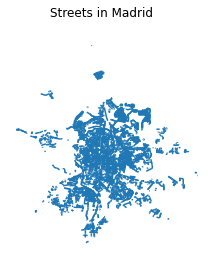

In [41]:
# Setup figure and axis
f, ax = plt.subplots(1)
# Add layer of polygons on the axis
streets.plot(ax=ax)
ax.set_axis_off()
# Add figure title
f.suptitle("Streets in Madrid")
# Display
plt.show()

### Changing the size of the map

The size of the plot is changed equally easily in this context. The only difference is that it is specified when we create the figure with the argument `figsize`. The first number represents the width, the X axis, and the second corresponds with the height, the Y axis.

/opt/conda/lib/python3.9/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/opt/conda/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


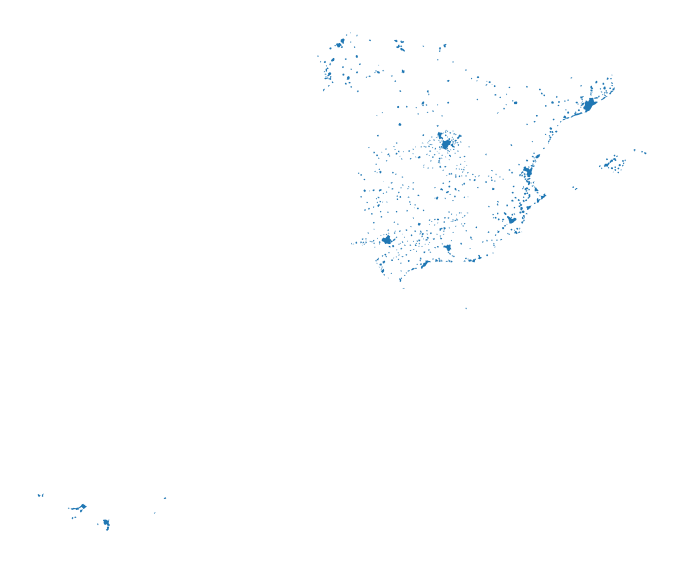

In [42]:
# Setup figure and axis with different size
f, ax = plt.subplots(1, figsize=(12, 12))
# Add layer of polygons on the axis
cities.plot(ax=ax)
ax.set_axis_off()
# Display
plt.show()

### Modifying borders

Border lines for geometries can sometimes distort proper interpretation of a map. In those cases, it is useful to know how they can be modified. Although not too complicated, the way to access borders in GeoPandas is not as straightforward as it is the case for other aspects of the map, such as size or frame. Let us first see the code to make the *lines thicker* and *black*, and then we will work our way through the different steps:

/opt/conda/lib/python3.9/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/opt/conda/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


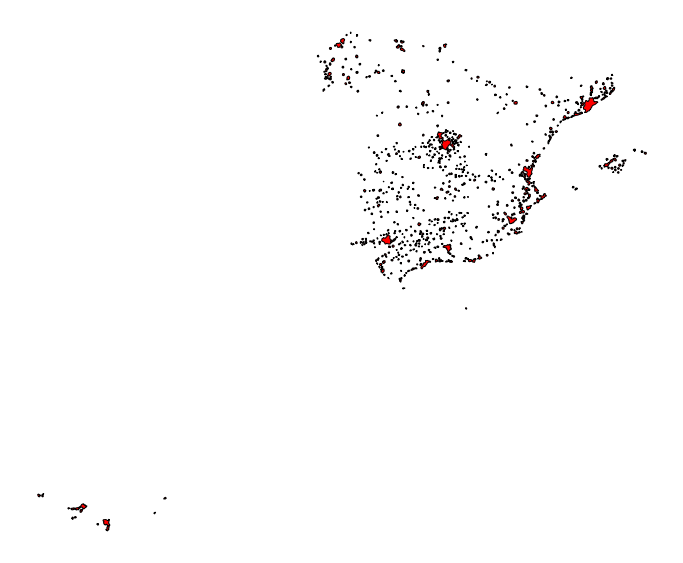

In [43]:
# Setup figure and axis
f, ax = plt.subplots(1, figsize=(12, 12))
# Add layer of polygons on the axis, set fill color (`facecolor`) and boundary
# color (`edgecolor`)
cities.plot(
    linewidth=1, 
    facecolor='red', 
    edgecolor='black', 
    ax=ax
);
ax.set_axis_off()

Note how the lines are thicker. In addition, all the polygons are colored in the same (default) color, light red. However, because the lines are thicker, we can only see the polygon filling for those cities with an area large enough.

Let us examine line by line what we are doing in the code snippet:

* We begin by creating the figure (`f`) object and one axis inside it (`ax`) where we will plot the map.
* Then, we call `plot` as usual, but pass in two new arguments: `linewidth` for the width of the line; `facecolor`, to control the color each polygon is filled with; and `edgecolor`, to control the color of the boundary.

This approach works very similarly with other geometries, such as lines. For example, if we wanted to plot the streets in red, we would simply:

/opt/conda/lib/python3.9/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/opt/conda/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


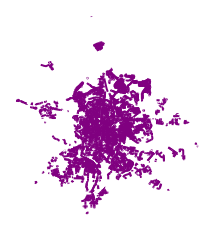

In [44]:
# Setup figure and axis
f, ax = plt.subplots(1)
# Add layer with lines, set them red and with different line width
# and append it to the axis `ax`
streets.plot(linewidth=2, color='purple', ax=ax)
ax.set_axis_off()

Important, note that in the case of lines the parameter to control the color is simply `color`. This is because lines do not have an area, so there is no need to distinguish between the main area (`facecolor`) and the border lines (`edgecolor`).

## Composing multi-layer maps

So far we have considered many aspects of plotting *a single* layer of data. However, in many cases, an effective map will require more than one: for example we might want to display streets on top of the polygons of neighborhoods, and add a few points for specific locations we want to highlight. At the very heart of maps is the possibility to combine spatial information from different sources by overlaying it on top of each other, and this is fully supported in Python.

For this section, let's select only Madrid from the `cities` table and convert it to lat/lon so it's aligned with the streets and POIs layers:

In [45]:
mad_reproj = cities.loc[[12], :].to_crs(epsg=4326)
mad_reproj

,city_id,n_buildings,geometry
12,ci012,193714,"POLYGON ((-3.90016 40.30421, -3.90019 40.30457..."


Combining different layers on a single map boils down to adding each of them to the same axis in a sequential way, as if we were literally overlaying one on top of the previous one. For example, let's plot the boundary of Madrid and its bars:

/opt/conda/lib/python3.9/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/opt/conda/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/opt/conda/lib/python3.9/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/opt/conda/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/opt/conda/lib/python3.9/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are depreca

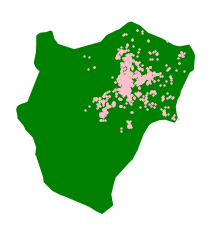

In [46]:
# Setup figure and axis
f, ax = plt.subplots(1)
# Add a layer with polygon on to axis `ax`
mad_reproj.plot(ax=ax, color="green")
# Add a layer with lines on top in axis `ax`
pois.plot(ax=ax, markersize=2, color="pink")
ax.set_axis_off()

So what happens if we plot data in different CRS on the same map?

In [47]:
mad = cities.loc[[12], :]

# Setup figure and axis
f, ax = plt.subplots(1)
# Add a layer with polygon on to axis `ax`
mad.plot(ax=ax, color="green")
# Add a layer with lines on top in axis `ax`
pois.plot(ax=ax, color="pink")
ax.set_axis_off()

/opt/conda/lib/python3.9/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/opt/conda/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/opt/conda/lib/python3.9/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/opt/conda/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/opt/conda/lib/python3.9/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are depreca

GeoPandas just reads the coordinates 'as they are' - and in this case Madrid and the bars in Madrid end up very far from each other because of CRS-mismatch.

## Exporting maps

Once we have produced a map we are content with, we might want to save it to a file so we can include it into a report, article, website, etc. To export maps with GeoPandas we use   `plt.savefig` before showing it with `plt.show` at the end of the code block. For example to save the previous map into a `png` file into a sub-directory 'files':

/opt/conda/lib/python3.9/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/opt/conda/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/opt/conda/lib/python3.9/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/opt/conda/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/opt/conda/lib/python3.9/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are depreca

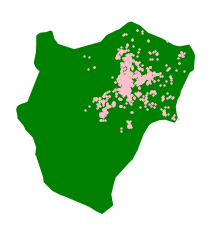

In [48]:
# Setup figure and axis
f, ax = plt.subplots(1)
# Add a layer with polygon on to axis `ax`
mad_reproj.plot(ax=ax, color="green")
# Add a layer with lines on top in axis `ax`
pois.plot(ax=ax, markersize=2, color="pink")
ax.set_axis_off()
# Save figure to a PNG file
plt.savefig('files/madrid_bars.png')

If you now check on the files folder, you'll find a `png` (image) file with the map.

The command `plt.savefig` contains a large number of options and additional parameters to tweak. Given the size of the figure created is not very large, we can increase this with the argument `dpi`, which stands for "dots per inch" and it's a standard measure of resolution in images. For example, for a high quality image, we could use 500:

/opt/conda/lib/python3.9/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/opt/conda/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/opt/conda/lib/python3.9/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/opt/conda/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/opt/conda/lib/python3.9/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are depreca

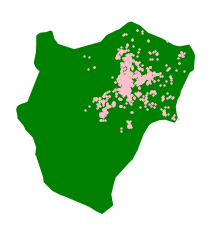

In [49]:
# Setup figure and axis
f, ax = plt.subplots(1)
# Add a layer with polygon on to axis `ax`
mad_reproj.plot(ax=ax, color="green")
# Add a layer with lines on top in axis `ax`
pois.plot(ax=ax, markersize=2, color="pink")
ax.set_axis_off()
# Save figure to a PNG file
plt.savefig('files/madrid_bars.png', dpi=500)

## Adding base layers from web sources

Many single datasets lack context when displayed on their own. A common approach to alleviate this is to use web tiles, which are a way of quickly obtaining geographical context to present spatial data. In Python, we can use [`contextily`](https://contextily.readthedocs.io) to pull down tiles and display them along with our own geographic data. Notice that this requires an internet connection, if you have not saved the base maps locally!

We can begin by creating a map in the same way we would do normally, and then use the `add_basemap` command to add a basemap:

Note: The default contextily basemap, Stamen, is broken since 2023, so we need to specify another one, for example: `source=cx.providers.CartoDB.Positron`

/opt/conda/lib/python3.9/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/opt/conda/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


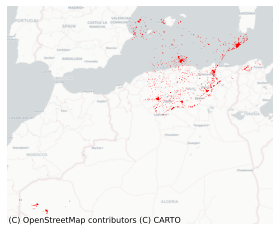

In [50]:
ax = cities.plot(color="red")
ax.set_axis_off()
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron);

Oops, something went wrong! We also need to tell contextily which CRS to use:

/opt/conda/lib/python3.9/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/opt/conda/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


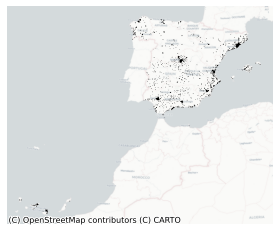

In [51]:
ax = cities.plot(color="black")
ax.set_axis_off()
cx.add_basemap(ax, crs=cities.crs, source=cx.providers.CartoDB.Positron);

Web tiles can be integrated with other features of maps in a similar way as we have seen above. So, for example, we can change the size of the map, and remove the axis. Let's use Madrid for this example:

/opt/conda/lib/python3.9/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/opt/conda/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


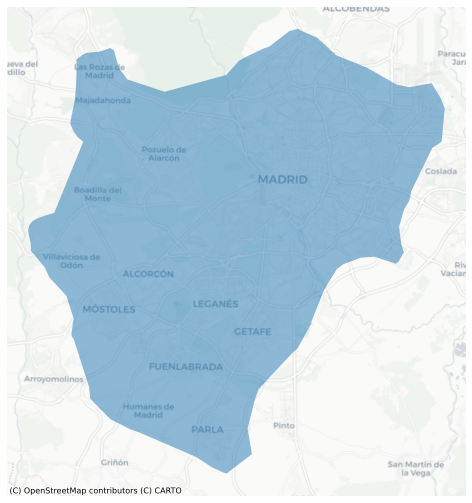

In [52]:
f, ax = plt.subplots(1, figsize=(9, 9))
mad.plot(alpha=0.5, ax=ax)
ax.set_axis_off()
cx.add_basemap(ax, crs=mad.crs, source=cx.providers.CartoDB.Positron)

`contextily` offers a lot of options in terms of the sources and providers you can use to create your basemaps. For example, we can use satellite imagery instead:

/opt/conda/lib/python3.9/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/opt/conda/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


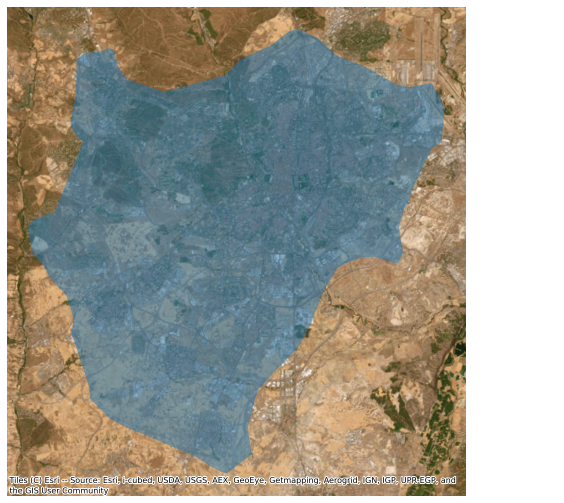

In [53]:
f, ax = plt.subplots(1, figsize=(9, 9))
mad.plot(alpha=0.5, ax=ax)
cx.add_basemap(
    ax, 
    crs=mad.crs,
    source=cx.providers.Esri.WorldImagery
)
ax.set_axis_off()

Have a look the documentation [https://contextily.readthedocs.io/en/latest/](https://contextily.readthedocs.io/en/latest/) or at this Twitter thread to get some further ideas on providers:

In [54]:
from IPython.display import HTML
tweet = """
<blockquote class="twitter-tweet" data-lang="en"><p lang="et" dir="ltr">Terrain maps <a href="https://t.co/VtN9bGG5Mt">pic.twitter.com/VtN9bGG5Mt</a></p>&mdash; Dani Arribas-Bel (@darribas) <a href="https://twitter.com/darribas/status/1157297596689539072?ref_src=twsrc%5Etfw">August 2, 2019</a></blockquote>
<script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>
"""
HTML(tweet)

## Summary

That's it! In this section we have learned how to:

1. Load and save vector data using GeoPandas
2. Do different spatial operations such as buffers and point-in-polygon queries
3. Using Matplotlib to make maps + how to modify basic mapping settings

# PART 2: Map projections

We have already discussed why it is important to check if your data are in the correct CRS, based on what you will use it for, and above we saw why data must be in the same CRS when plotted on the same map.
    
<img src="files/Map-projections.png">

*Source: XKCD, See a full comic about ["What your favorite map projection tells about you"](https://xkcd.com/977/)*.

## Coordinate reference system (CRS) in Geopandas

Luckily, defining and changing projections is easy using Geopandas and a library called [pyproj](https://pyproj4.github.io/pyproj/stable/). In this tutorial we will see how to **retrieve the coordinate reference system information** from the data, and how to **re-project** the data into another crs. We will re-project a data file from
WGS84 (lat, lon coordinates) into a Lambert Azimuthal Equal Area projection which is the [recommended projection for Europe](http://mapref.org/LinkedDocuments/MapProjectionsForEurope-EUR-20120.pdf) by European Commission.

For this tutorial we will be using a Geopackage called `Europe_borders.gpkg` representing the country borders in Europe.
When reading the data into `GeoDataFrame` with Geopandas crs information is automatically stored into the `.crs` attribute of the GeoDataFrame.

In Shapefiles, information about the coordinate reference system is stored in the `.prj` -file. If this file is missing, you might be in trouble!

Let's start by reading the data from the `Europe_borders.gpkg` file and checking the `crs`: 

In [ ]:
# Read the file
fp = "files/europe_borders.gpkg"
data = gpd.read_file(fp)

In [ ]:
# Check the coordinate reference system
data.crs

What we see here is in fact a **CRS object** from the **pyproj** module. 

The EPSG code of our geodataframe is`4326`, which refers to the WGS84 coordinate system.

You can find a lot of information and lists of available coordinate reference systems from:

  - [www.spatialreference.org](http://spatialreference.org/)
  - [www.proj4.org](https://proj4.org/operations/projections/)
  - [www.mapref.org](http://mapref.org/CollectionofCRSinEurope.html)

Let's continue by checking the values in our `geometry`-column to verify that the CRS of our GeoDataFrame seems correct. In the case of EPSG:4326, coordinates should be between -180 and 180° longitude and -90 and 90° latitude.

In [ ]:
data['geometry'].head()

As we can see, the coordinate values of the Polygons indeed look like latitude and longitude values, so everything seems to be in order.

WGS84 projection is not really a good one for representing European borders on a map (areas get distorted), so let's convert those geometries into Lambert Azimuthal Equal Area (LAEA) projection ([EPSG: 3035](http://spatialreference.org/ref/epsg/etrs89-etrs-laea/)) which is the recommended projection by European Comission.

Changing the projection is simple [to do](https://geopandas.org/en/stable/docs/user_guide/projections.html#re-projecting) in GeoPandas with the `.to_crs()`-function, which is a built-in function of the GeoDataFrame. The function has two alternative parameters 1) `crs` and 2) `epgs` that can be used to make the coordinate transformation and re-project the data into the CRS that you want to use.

Let's re-project our data into `EPSG:3035` using the `epsg`-parameter:

In [ ]:
# Let's make a backup copy of our data
data_wgs84 = data.copy()

# Reproject the data
data = data.to_crs(epsg=3035)

# Check the new geometry values
data['geometry'].head()

In [ ]:
data.crs

And here we go, the coordinate values in the geometries have changed! Now we have successfully changed the projection of our layer into a new one, i.e. to `ETRS-LAEA` projection. 

To really understand what is going on, it is good to explore our data visually. Let's compare the datasets by making
maps out of them.


In [ ]:
# Make subplots that are next to each other
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))

# Plot the data in WGS84 CRS
data_wgs84.plot(ax=ax1, facecolor='gray')

# Add title
ax1.set_title("WGS84")

# Plot the one with ETRS-LAEA projection
data.plot(ax=ax2, facecolor='blue')

#ax1.set_axis_off()

# Add title
ax2.set_title("ETRS Lambert Azimuthal Equal Area projection")

#ax2.set_axis_off()

# Set aspect ratio as 1
ax1.set_aspect(aspect=1)
ax2.set_aspect(aspect=1)

# Remove empty white space around the plot
plt.tight_layout()

Indeed, the maps look quite different, and the re-projected one looks much better in Europe as the areas especially in the north are more realistic and not so stretched as in WGS84.

Finally, let's save our projected layer so that we can use it later. Note, even if the CRS information is stored in the file, it can be a good idea also to include CRS info in the filename:

In [ ]:
# Save to disk
data.to_file("files/europe_borders_epsg3035.gpkg")

## Global map projections

Finally, let's play around with global map projections. The files folder contains a layer `ne_110m_admin_0_countries.shp` that represents the country borders of the world. The data was downloaded from https://www.naturalearthdata.com/. 

In [ ]:
# Read in data
fp = "files/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp" 

admin = gpd.read_file(fp)

# Check input crs
admin.crs

In [ ]:
# Set fig size
plt.rcParams['figure.figsize'] = [12, 6]

#Plot in original crs
admin.plot()
plt.title("WGS84");


In [ ]:
# Re-project and plot
admin.to_crs('EPSG:3785').plot()

plt.axis('off')
plt.title("Web mercator");

In [ ]:
# Re-project and plot
admin.to_crs("ESRI:54012").plot()

plt.title("Eckert IV");

It is also possible to modify projections - for example to be centered on a specific country:

In [ ]:
# Define an orthographic projection, centered in Denmark! from: http://www.statsmapsnpix.com/2019/09/globe-projections-and-insets-in-qgis.html
ortho = CRS.from_proj4("+proj=ortho +lat_0=56.3 +lon_0=9.5 +x_0=0 +y_0=0 +a=6370997 +b=6370997 +units=m +no_defs")

# Re-project and plot
admin.to_crs(ortho).plot()

# Remove x and y axis
plt.axis('off')
plt.title("Orthographic");

For more advanced options for dealing with CRS, see the last section.

## EXTRA: Dealing with different CRS formats

There are various ways to present Coordinate Reference System information, such as [PROJ strings](https://proj.org/usage/quickstart.html), `EPSG-codes`, `Well-Known-Text (WKT)`, `JSON`. It is likely that you will encounter some of these when working with spatial data obtained from different sources. Being able to convert the CRS information from one format to another is needed every now and then, hence, it is useful to know a few tricks how to do this.

Luckily, dealing with CRS information is easy in Python using the [pyproj](https://pyproj4.github.io/pyproj/stable/) library. In fact, `pyproj` is a Python wrapper around a software called [PROJ](https://proj.org/) (maintained by [OSGeo](https://www.osgeo.org/) community), which is widely used tool for conducting coordinate transformations in various GIS softwares. `Pyproj` is also used under the hood in Geopandas, and it handles all the CRS definitions and coordinate transformations (reprojecting from CRS to another as we did earlier).

### Overview

The following code cell prints out a summary summary of different ways of representing crs information using pyproj CRS. Here, we use the crs of the original European borders layer as a starting point:

In [ ]:
### Import CRS class from pyproj
from pyproj import CRS

In [ ]:
# PROJ dictionary:
crs_dict = data_wgs84.crs

# pyproj CRS object:
crs_object = CRS(data_wgs84.crs)

# EPSG code (here, the input crs information is a bit vague so we need to lower the confidence threshold)
crs_epsg = CRS(data_wgs84.crs).to_epsg(min_confidence=25)

# PROJ string
crs_proj4 = CRS(data_wgs84.crs).to_proj4()

# Well-Known Text (WKT)
crs_wkt = CRS(data_wgs84.crs).to_wkt()

In [ ]:
print("PROJ dictionary:\n", crs_dict)
print("\nCRS object:\n", crs_object)
print("\nEPSG code: \n", crs_epsg)
print("\nPROJ string: \n", crs_proj4)
print("\nWell-Known Text (WKT):\n",crs_wkt) 

### Pyproj CRS object

Next, let's see how it is possible to easily extract useful information from CRS, and transform CRS information from format to another. `pyproj` -library has a [class](https://docs.python.org/3/tutorial/classes.html) called [CRS](https://pyproj4.github.io/pyproj/dev/api/crs.html) that provides many useful functionalities for dealing with CRS information.

In [ ]:
# Let's see the current CRS of our data
print(data.crs)

Printing the crs using the print() statement gives us the EPSG code. 

However, let's see what the same information looks like in other formats such as `WKT` or `Proj4` text. For this we need to use the `CRS` class.  

In [ ]:
# Initialize the CRS class for epsg code 3035:
crs_object = CRS.from_epsg(3035)
crs_object

As we can see, the `CRS` object contains information about the coordinate reference system such as the **name** of the CRS (ETRS89/LAEA Europe), the **area** where the CRS is in use (*Europe* with bounds *(-16.1, 32.88, 40.18, 84.17)*), and the **datum** (European Terrestrial Reference System 1989). 

We can also easily parse this information individually as follows: 

In [ ]:
# Name
print("Name:", crs_object.name)

# Coordinate system
print("Coordinate system:", crs_object.coordinate_system)

# Bounds of the area where CRS is used
print("Bounds:", crs_object.area_of_use.bounds)

You can explore all the possible information that can be extracted from the CRS by typing `crs_object.` and pressing Tabulator. 

Let's see how we can convert the crs information from one format to another. Quite often it is useful to know the EPSG code of the CRS. Next, we will conduct a few transformations to demonstrate the capabilities of the `CRS` class.

In [ ]:
# Retrieve CRS information in WKT format
crs_wkt = crs_object.to_wkt()
print(crs_wkt)

As we can see, the **WKT** format contains a *lot* of information. Typically, e.g. the `.prj` file of a Shapefile contains the information in this format. Let's see how it is possible to extract **EPSG** code from this. For doing it, we need to re-initialize the CRS object, this time from the WKT text presentation.   

In [ ]:
# Retrieve EPSG code from WKT text
epsg = CRS(crs_wkt).to_epsg()
print(epsg)

**HINT**: A module called [PyCRS](https://github.com/karimbahgat/PyCRS) can also be useful library as it contains information and supports many different coordinate reference definitions, such as OGC WKT (v1), ESRI WKT, Proj4, and any EPSG, ESRI, or SR-ORG code available from spatialreference.org.

## Summary

That's it! In this section we have learned how to:

1. Reproject (transform) the geometries in a GeoDataFrame from one CRS to another using the `to_crs()`-method
2. Define the coordinate reference system in different formats using `pyproj` `CRS`